# Q1 

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage.interpolation import zoom
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet

fname = 'einstein.jpg'
i_width = 640
i_height = 480

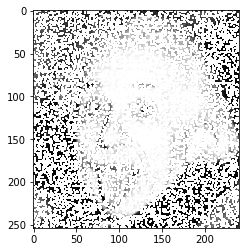

In [36]:
np.random.seed(0)
sampling_threshold = 0.8
image = zoom(np.asarray(Image.open(fname).convert("L")), 0.2).astype(np.float)
image_ss = image.copy()
mask = np.random.uniform(size=image.shape) < 1 - sampling_threshold
image_ss[mask] = np.nan
plt.imshow(image_ss, cmap='gray', vmin=0, vmax=255)
plt.show()

In [37]:
np.isnan(image_ss).sum()

12419

## (a)

In [38]:
train = []
test = []
val = []

m,n = image_ss.shape

for i in range(m):
    for j in range(n):
        if not mask[i,j]:
            train.append([i,j])
            val.append(image[i,j])
        else:
            test.append([i,j])   
            
X = np.array(train)
test = np.array(test)
y = np.array(val)
test.shape

(12419, 2)

## (b) 

In [4]:
# RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=100, random_state=24)
# cv_scores_rfr = cross_val_score(rfr, X, y, cv=5, scoring='neg_mean_squared_error')
# GradientBoostingRegressor
gbr = GradientBoostingRegressor(n_estimators=100, random_state=24)
# cv_scores_gbr = cross_val_score(gbr, X, y, cv=5, scoring='neg_mean_squared_error')
# AdaBoostRegressor
abr = AdaBoostRegressor(n_estimators=100, random_state=24)
# cv_scores_abr = cross_val_score(abr, X, y, cv=5, scoring='neg_mean_squared_error')

d = {rfr:'RandomForestRegressor', gbr:'GradientBoostingRegressor',abr:'AdaBoostRegressor'}

param_grid = {'n_estimators': [50 + i*50 for i in range(0, 10)]}

for model in [rfr, gbr, abr]:
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

    # Fit the model with grid search
    grid_search.fit(X, y)

    # Best parameters and model
    best_params = grid_search.best_params_
    best_mse = grid_search.best_score_

    print('Best n_estimators for {}: '.format(d[model]), best_params['n_estimators'])
    print('Best MSE: ', -best_mse)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best n_estimators for RandomForestRegressor:  500
Best MSE:  4370.344531202856
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best n_estimators for GradientBoostingRegressor:  500
Best MSE:  4548.288629433499
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best n_estimators for AdaBoostRegressor:  50
Best MSE:  5635.075264654358


In [39]:
# Gaussian feature map regression

class GaussianKernelFeatures(BaseEstimator, TransformerMixin):
    """
    Gaussian feature map with fixed centers and sigma.

    centers: ndarray of shape (n_centers, n_features)
        The centers of the Gaussian functions.

    sigma: float
        The sigma of the Gaussian functions.
    """
    def __init__(self, centers, sigma):
        self.centers = centers
        self.sigma = sigma

    def fit(self, X, y=None):
        return self  # Nothing to do here

    def transform(self, X):
        """
        Apply the Gaussian feature map to the data.

        X: ndarray of shape (n_samples, n_features)
            The input data.
        """
        n_samples, n_features = X.shape
        if n_features != self.centers.shape[1]:
            raise ValueError("The number of features in X must be equal to the number of features in the centers.")

        X_expanded = np.expand_dims(X, 1)
        centers_expanded = np.expand_dims(self.centers, 0)

        differences = X_expanded - centers_expanded
        squared_differences = np.sum(differences ** 2, axis=2)
        features = np.exp(-squared_differences / (2 * self.sigma ** 2))

        return features 

In [40]:
n_centers = 5  # For example, 5 centers per feature
# Create a grid of centers
x_centers = np.linspace(0, 1, n_centers)
y_centers = np.linspace(0,1, n_centers)
centers = np.array(np.meshgrid(x_centers, y_centers)).T.reshape(-1, 2)

gkf = GaussianKernelFeatures(centers, sigma=1)
scaler = StandardScaler()
estimator = LinearRegression(fit_intercept=False)
gfmr = make_pipeline(scaler, gkf, estimator)

param_grid = {'gaussiankernelfeatures__sigma': [0.1+0.1*i for i in range(0, 10)]}
grid_search = GridSearchCV(gfmr, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit the model with grid search
grid_search.fit(X, y)

# Best parameters and model
best_params = grid_search.best_params_
best_mse = grid_search.best_score_

print('Best sigma: ', best_params['gaussiankernelfeatures__sigma'])
print('Best MSE: ', -best_mse)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best sigma:  0.8
Best MSE:  4383.481971134156


#### We can see that after parameter tuning,  RandomForestRegressor produces the best mean-squared cross validation error.

## (c) 

In [30]:
def show_complete_img(image, image_ss, test, pred):
    temp = image_ss.copy()
    for i in range(len(test)):
        temp[int(test[i][0]),int(test[i][1])] = pred[i]
    # Create a figure and a set of subplots
    fig, axs = plt.subplots(1, 2)  # 1 row, 2 columns
    # Display first image
    axs[0].imshow(temp, cmap='gray', vmin=0, vmax=255)
    axs[0].set_title('Interpolated Image')
    axs[0].axis('off')  # Turn off axis

    # Display second image
    axs[1].imshow(image, cmap='gray', vmin=0, vmax=255)
    axs[1].set_title('Original Image')
    axs[1].axis('off')  # Turn off axis

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


MSE for RandomForestRegressor is 156.07103819148082


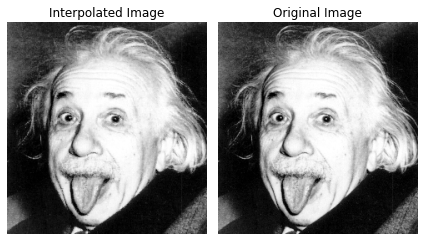

MSE for GradientBoostingRegressor is 971.9214491053767


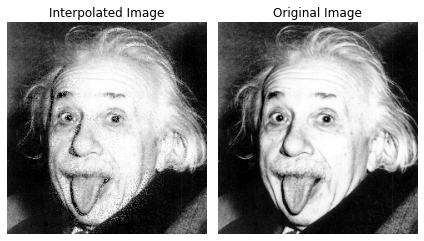

MSE for AdaBoostRegressor is 3677.1363099720184


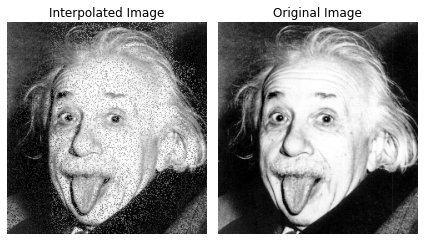

MSE for GuassianFeatureMapRegression is 1998.7997067734066


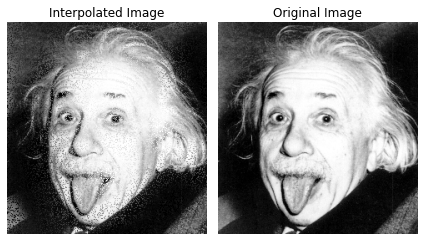

In [7]:
label = np.array([image[i[0],i[1]] for i in test])
gkf = GaussianKernelFeatures(centers, sigma=0.8)
scaler = StandardScaler()
estimator = LinearRegression(fit_intercept=False)
gfmr = make_pipeline(scaler, gkf, estimator)

models = [RandomForestRegressor(n_estimators=50, random_state=24),
          GradientBoostingRegressor(n_estimators=500, random_state=24),
          AdaBoostRegressor(n_estimators=50, random_state=24),
          gfmr
         ]
names = ['RandomForestRegressor','GradientBoostingRegressor','AdaBoostRegressor','GuassianFeatureMapRegression']
for i in range(len(models)):
    model = models[i]
    model.fit(X,y)
    pred_y = model.predict(test)
    mse = mean_squared_error(pred_y, label)
    print('MSE for {} is {}'.format(names[i],mse))
    show_complete_img(image,image_ss,test,pred_y)

#### RandomForestRegressor produces a result closest to the true image and the result is also the smoothest one. The MSE on the prediction set of RandomForestRegressor is also the smallest.

## (d) 

In [41]:
estimator = ElasticNet(alpha=1.0, l1_ratio=0.5)
gfmr_elas = make_pipeline(scaler, gkf, estimator)

param_grid = {'gaussiankernelfeatures__sigma': [0.1+0.1*i for i in range(0, 10)], 
              'elasticnet__alpha':[0.1*i for i in range(11)],
              'elasticnet__l1_ratio':[0.1*i for i in range(11)]}
grid_search = GridSearchCV(gfmr_elas, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit the model with grid search
grid_search.fit(X, y)

# Best parameters and model
best_params = grid_search.best_params_
best_mse = grid_search.best_score_

print('Best params: ', best_params)
print('Best MSE: ', -best_mse)

Fitting 5 folds for each of 1210 candidates, totalling 6050 fits
Best params:  {'elasticnet__alpha': 0.0, 'elasticnet__l1_ratio': 0.0, 'gaussiankernelfeatures__sigma': 1.0}
Best MSE:  3882.6301236426502


#### GridSearching tells us it is better not to include the $L_1-L_2$ elastic net regularization. 

MSE for GuassianFeatureMap with ElasticNet is 3031.368813887843


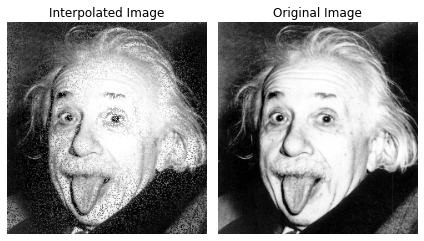

In [42]:
gkf = GaussianKernelFeatures(centers, sigma=1)
scaler = StandardScaler()
estimator = ElasticNet(alpha=0., l1_ratio=0.)
gfmr_elas = make_pipeline(scaler, gkf, estimator)
gfmr_elas.fit(X,y)
pred_y = gfmr_elas.predict(test)
mse = mean_squared_error(pred_y, label)
print('MSE for GuassianFeatureMap with ElasticNet is {}'.format(mse))
show_complete_img(image,image_ss,test,pred_y)

## (e)

In [8]:
image_ss[np.isnan(image_ss)] = -999
padded_img = np.pad(image_ss,((1, 1), (1, 1)),mode='constant', constant_values=-999)
X = []
y = []
test = []
for i in range(1, m+1):
    for j in range(1, n+1):
        if image_ss[i-1,j-1] != -999:
            X.append([i-1,j-1,padded_img[i-1,j],padded_img[i+1,j],padded_img[i,j-1],padded_img[i,j+1]])
            y.append(image[i-1,j-1])
        else:
            test.append([i-1,j-1,padded_img[i-1,j],padded_img[i+1,j],padded_img[i,j-1],padded_img[i,j+1]])
            
X = np.array(X)
test = np.array(test)
y = np.array(y)

In [9]:
test.shape

(12419, 6)

In [28]:
# RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=100, random_state=24)
# cv_scores_rfr = cross_val_score(rfr, X, y, cv=5, scoring='neg_mean_squared_error')
# GradientBoostingRegressor
gbr = GradientBoostingRegressor(n_estimators=100, random_state=24)
# cv_scores_gbr = cross_val_score(gbr, X, y, cv=5, scoring='neg_mean_squared_error')
# AdaBoostRegressor
abr = AdaBoostRegressor(n_estimators=100, random_state=24)
# cv_scores_abr = cross_val_score(abr, X, y, cv=5, scoring='neg_mean_squared_error')

d = {rfr:'RandomForestRegressor', gbr:'GradientBoostingRegressor',abr:'AdaBoostRegressor'}

param_grid = {'n_estimators': [50 + i*50 for i in range(0, 10)]}

for model in [rfr, gbr, abr]:
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

    # Fit the model with grid search
    grid_search.fit(X, y)

    # Best parameters and model
    best_params = grid_search.best_params_
    best_mse = grid_search.best_score_

    print('Best n_estimators for {}: '.format(d[model]), best_params['n_estimators'])
    print('Best MSE: ', -best_mse)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best n_estimators for RandomForestRegressor:  500
Best MSE:  170.09337092488428
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best n_estimators for GradientBoostingRegressor:  500
Best MSE:  190.14762913522458
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best n_estimators for AdaBoostRegressor:  50
Best MSE:  594.2956374408486


MSE for RandomForestRegressor is 144.71553239938805


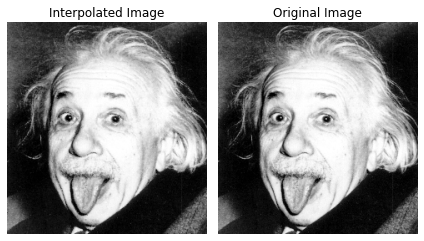

MSE for GradientBoostingRegressor is 173.65502802561852


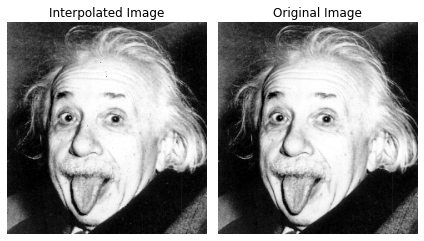

MSE for AdaBoostRegressor is 515.4715745845065


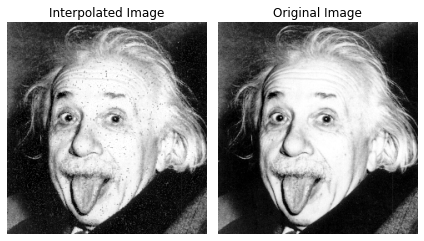

In [16]:
models = [RandomForestRegressor(n_estimators=500, random_state=24),
          GradientBoostingRegressor(n_estimators=500, random_state=24),
          AdaBoostRegressor(n_estimators=50, random_state=24),
         ]
names = ['RandomForestRegressor','GradientBoostingRegressor','AdaBoostRegressor']
for i in range(len(models)):
    model = models[i]
    model.fit(X,y)
    pred_y = model.predict(test)
    mse = mean_squared_error(pred_y, label)
    print('MSE for {} is {}'.format(names[i],mse))
    show_complete_img(image,image_ss,test,pred_y)

#### From the result, we can see that after augmenting our training data, the results GradientBoostingRegressor and AdaBoostRegressor have been imporved significantly, while RandomForestRegressor has been improved slightly and is still the best performing model.

# Q2

## (a) 

In [8]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt

class GenRelu(BaseEstimator, TransformerMixin):
    def __init__(self, locations, a=-1.):
        self.locations = locations
        self.a = a

    def fit(self, X, y=None):
        # No fitting necessary, but we implement the method to comply with scikit-learn's TransformerMixin
        return self

    def transform(self, X):
        X = np.array(X).reshape(-1, 1)
        # Calculate the Gaussian kernel feature map
        features = np.zeros((X.shape[0], len(self.locations)))
        for i, x0 in enumerate(self.locations):
            features[:, i] = (np.where(X-x0 < 0, 0, X-x0) + self.a * np.where(X-x0 > 0, 0, X-x0)).squeeze()
            
        return features


## (b) 

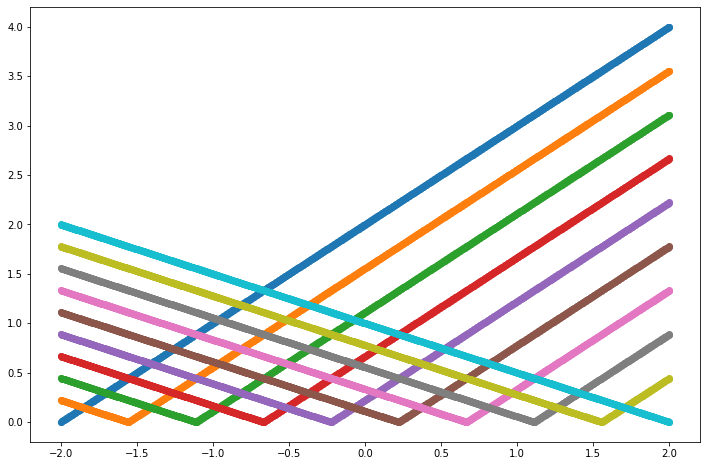

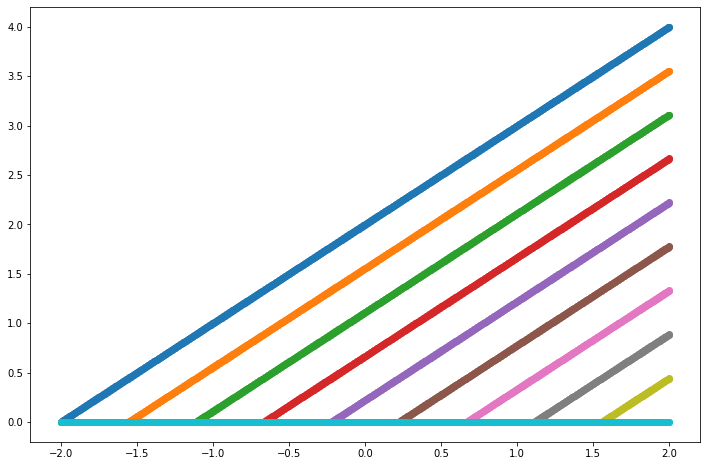

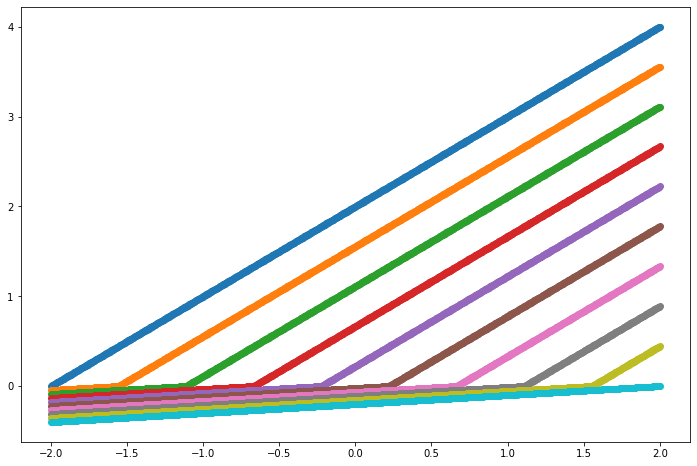

In [9]:
locations = np.linspace(-2, 2, 10)  # Define 10 locations for the centers of the Gaussian kernels
for a in [-0.5,0,0.1]:
    gr = GenRelu(locations=locations, a=a)
    x_predict = np.linspace(-2, 2, 1000)
    features = gr.fit_transform(x_predict)  # Apply the Gaussian kernel feature mapping
    plt.figure(figsize=(12,8))
    plt.plot(x_predict, features,'o')
    plt.show()

## (c) 

### Test on periodic data: 

C:\Users\22718\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


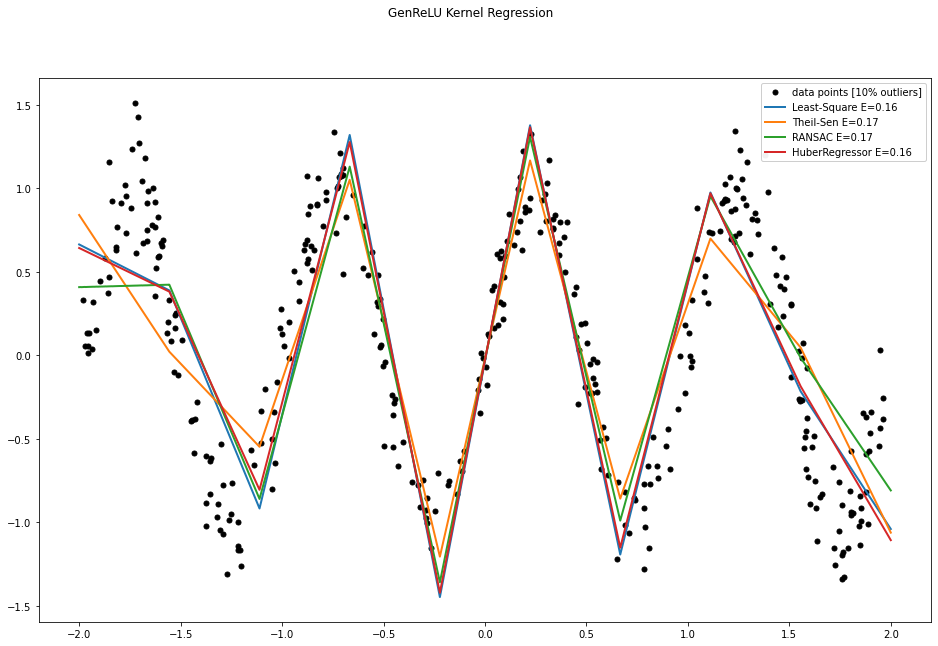

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RANSACRegressor, TheilSenRegressor, HuberRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

np.random.seed(42)
X = np.random.uniform(low=-2, high=2, size=500)

model = 'periodic'

if model == 'polynomial':
    y = 2. + 2 *X  + .4*X**2 - .4 * X**3
elif model == 'periodic':
    y = np.sin(20 * np.pi * 0.1 * X)
    
X = X[:,np.newaxis]

# random normal error
error = 0.2 * np.random.randn(y.shape[0])

# generate observations with additive noise
y += error 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)



gr = GenRelu(locations=locations,a=-1.5)

estimators = [('Least-Square', '-', 'C0', LinearRegression(fit_intercept=False)),
              ('Theil-Sen', '-', 'C1', TheilSenRegressor(random_state=42)),
              ('RANSAC', '-', 'C2', RANSACRegressor(random_state=42)),
              ('HuberRegressor', '-', 'C3', HuberRegressor())]

fig, ax = plt.subplots(1, 1, figsize=(16, 10))
fig.suptitle('GenReLU Kernel Regression')
ax.plot(X_train, y_train, 'o', ms=5, c='black',
        label='data points [10% outliers]')

for label, style, color, estimator in estimators:
    model = make_pipeline(gr, estimator)
    model.fit(X_train, y_train)
    mse = mean_squared_error(model.predict(X_test), y_test)
    y_predicted = model.predict(x_predict[:, None])
    ix = np.argsort(x_predict)
    ax.plot(x_predict[ix], y_predicted[ix], style, lw=2,
            color=color, label=label + ' E={:2.2g}'.format(mse))
ax.legend(loc='upper right', framealpha=0.95)
# ax.set(ylim=(-2, 8), xlabel='time [s]', ylabel='amplitude')
plt.show()

### Best parameter searching: 

In [18]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

estimator = LinearRegression(fit_intercept=False)

model = make_pipeline(gr, estimator)

param_distributions = {'genrelu__a': uniform(-2, 2)}

rnd_search = RandomizedSearchCV(model, param_distributions, n_iter=100, cv=3, scoring='neg_mean_squared_error', verbose=1)

# Fit the model with grid search
rnd_search.fit(X, y)

# Best parameters and model
best_params = rnd_search.best_params_
best_mse = rnd_search.best_score_

print('Best sigma: ', best_params)
print('Best MSE: ', -best_mse)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best sigma:  {'genrelu__a': -1.5067927300439508}
Best MSE:  0.1527581145145699


### When data is periodic, GenReLU Kernel Regression with least squre estimator has mse=0.16 on the test data while B-Spline has mse=0.11.

### Test on polynomial data: 

C:\Users\22718\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


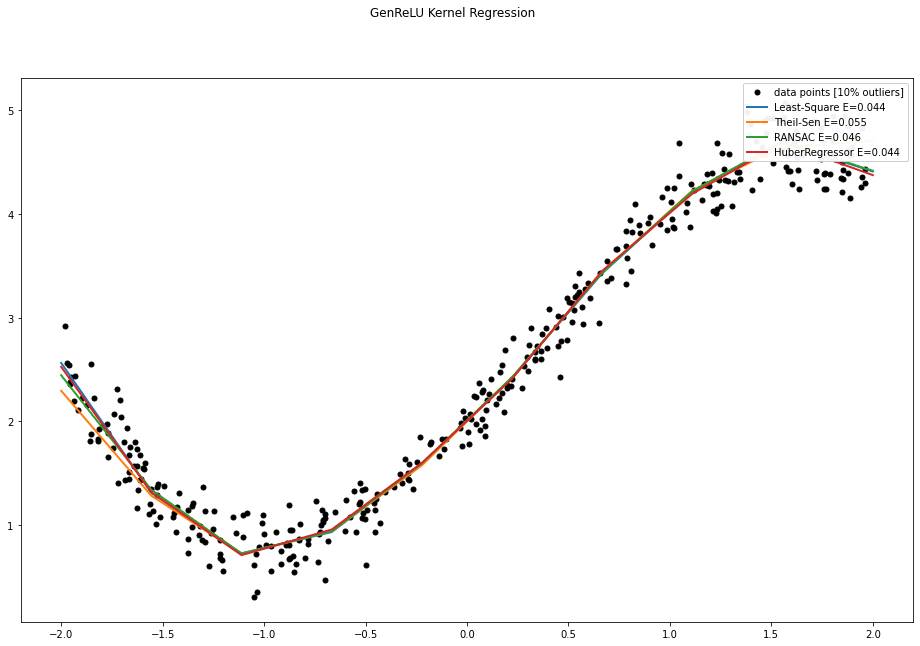

In [30]:
np.random.seed(42)
X = np.random.uniform(low=-2, high=2, size=500)

model = 'polynomial'

if model == 'polynomial':
    y = 2. + 2 *X  + .4*X**2 - .4 * X**3
elif model == 'periodic':
    y = np.sin(20 * np.pi * 0.1 * X)
    
X = X[:,np.newaxis]

# random normal error
error = 0.2 * np.random.randn(y.shape[0])

# generate observations with additive noise
y += error 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)



gr = GenRelu(locations=locations,a=-1.30059)

estimators = [('Least-Square', '-', 'C0', LinearRegression(fit_intercept=False)),
              ('Theil-Sen', '-', 'C1', TheilSenRegressor(random_state=42)),
              ('RANSAC', '-', 'C2', RANSACRegressor(random_state=42)),
              ('HuberRegressor', '-', 'C3', HuberRegressor())]

fig, ax = plt.subplots(1, 1, figsize=(16, 10))
fig.suptitle('GenReLU Kernel Regression')
ax.plot(X_train, y_train, 'o', ms=5, c='black',
        label='data points [10% outliers]')

for label, style, color, estimator in estimators:
    model = make_pipeline(gr, estimator)
    model.fit(X_train, y_train)
    mse = mean_squared_error(model.predict(X_test), y_test)
    y_predicted = model.predict(x_predict[:, None])
    ix = np.argsort(x_predict)
    ax.plot(x_predict[ix], y_predicted[ix], style, lw=2,
            color=color, label=label + ' E={:2.2g}'.format(mse))
ax.legend(loc='upper right', framealpha=0.95)
# ax.set(ylim=(-2, 8), xlabel='time [s]', ylabel='amplitude')
plt.show()

### Best parameter searching: 

In [28]:
estimator = LinearRegression(fit_intercept=False)

model = make_pipeline(gr, estimator)

param_distributions = {'genrelu__a': uniform(-2, 2)}

rnd_search = RandomizedSearchCV(model, param_distributions, n_iter=100, cv=3, scoring='neg_mean_squared_error', verbose=1)

# Fit the model with grid search
rnd_search.fit(X, y)

# Best parameters and model
best_params = rnd_search.best_params_
best_mse = rnd_search.best_score_

print('Best sigma: ', best_params)
print('Best MSE: ', -best_mse)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best sigma:  {'genrelu__a': -1.300593540508301}
Best MSE:  0.04208569395289676


### When data is polynomial, GenReLU Kernel Regression with least squre estimator has mse=0.044 on the test data while B-Spline also has mse=0.044.

## (d) 

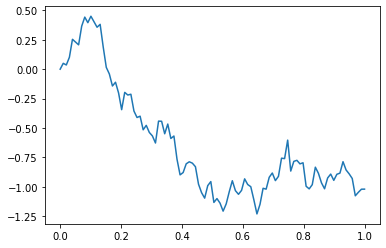

In [40]:
bm = [0]
X = np.linspace(0,1,100)
gap = X[1] - X[0]
coef = np.sqrt(gap)
np.random.seed(42) 
z = np.random.normal(0,1,99)
for i in range(99):
    next_val = bm[-1] + coef*z[i]
    bm.append(next_val)

plt.plot(X,bm)
plt.show()

Fitting 5 folds for each of 21 candidates, totalling 105 fits
For K=5:
Best sigma:  {'genrelu__a': 0.5}


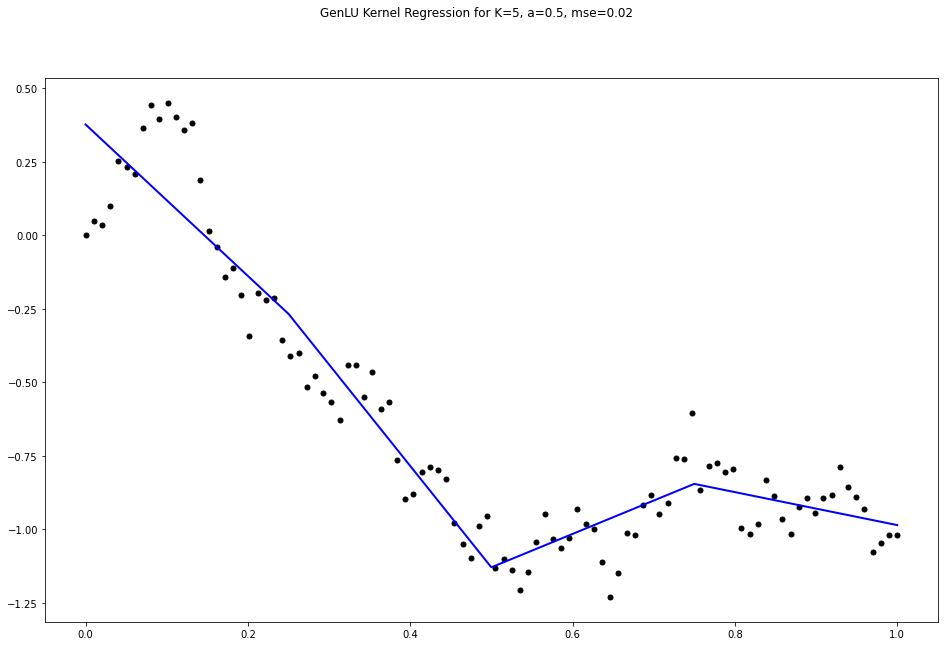

Fitting 5 folds for each of 21 candidates, totalling 105 fits
For K=20:
Best sigma:  {'genrelu__a': 1.0}


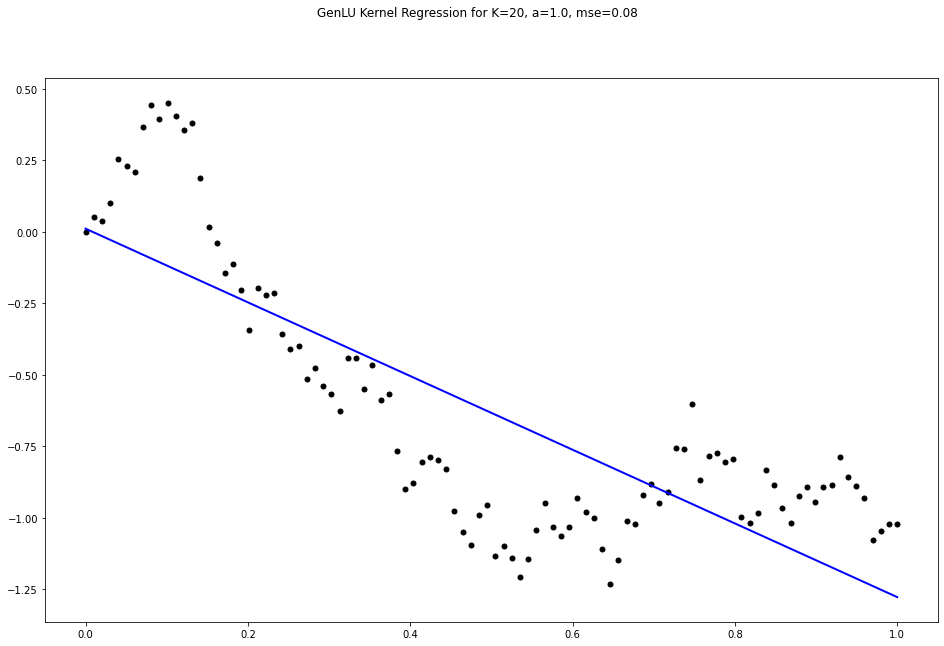

Fitting 5 folds for each of 21 candidates, totalling 105 fits
For K=50:
Best sigma:  {'genrelu__a': 1.0}


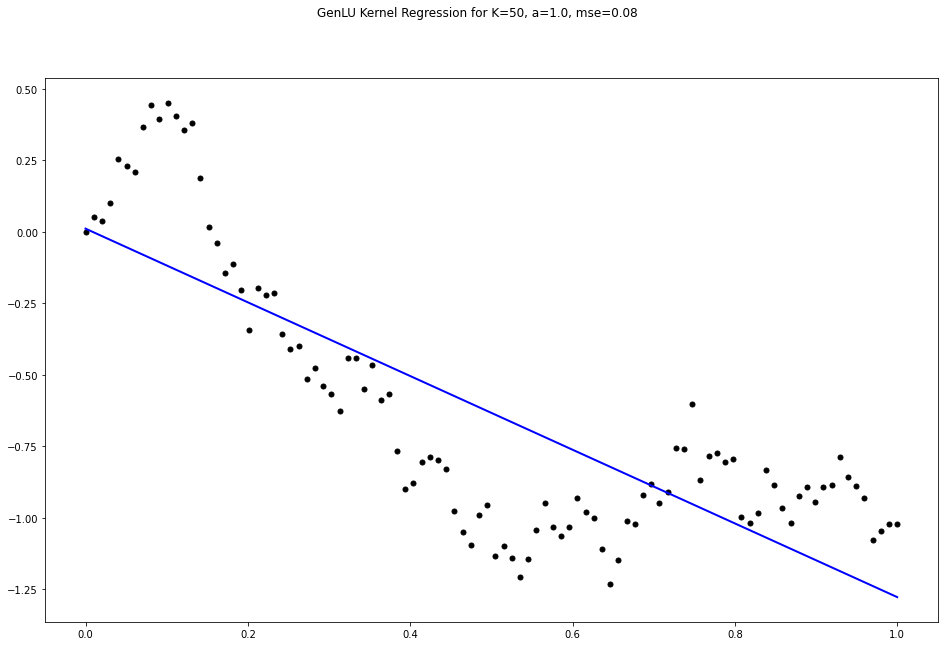

Fitting 5 folds for each of 21 candidates, totalling 105 fits
For K=100:
Best sigma:  {'genrelu__a': 0.0}


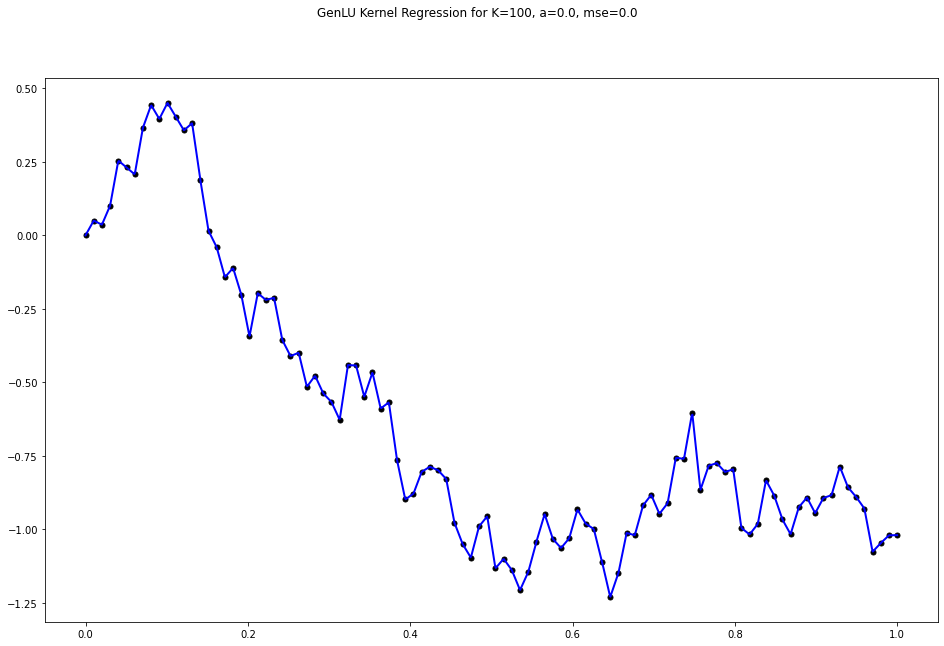

In [41]:
from sklearn.model_selection import GridSearchCV

X = X[:,np.newaxis]
x_pred = np.linspace(0,1,1000)

for k in [5,20,50,100]:
    locations = np.linspace(0,1,k)
    gr = GenRelu(locations)
    
    param_grid = {'genrelu__a': [-1.+0.1*i for i in range(0, 21)]}
    estimator = LinearRegression(fit_intercept=False)
    model = make_pipeline(gr, estimator)
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

    # Fit the model with grid search
    grid_search.fit(X, bm)
    # Best parameters and model
    best_params = grid_search.best_params_
    print('For K=' +str(k)+':')
    print('Best sigma: ', best_params)
    fig, ax = plt.subplots(1, 1, figsize=(16, 10))
    ax.plot(X, bm, 'o', ms=5, c='black')
    
    gr = GenRelu(locations,a=best_params['genrelu__a'])
    model = make_pipeline(gr, estimator)
    model.fit(X, bm)
    mse = mean_squared_error(model.predict(X), bm)
    y_predicted = model.predict(x_pred[:, None])
    ax.plot(x_pred, y_predicted, '-', lw=2, color='b')
    fig.suptitle('GenLU Kernel Regression for K={}, a={}, mse={}'\
                 .format(k,round(best_params['genrelu__a'],2),round(mse,2)))
    plt.show()

### We can see that as $K$ increases, the MSE first increases and then decreases. In the last case where $K=100$, the model is overfitted under the best parameter $a=0$.